In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf 
import edward as ed
from edward.models import Normal, MultivariateNormalTriL

In [2]:
def tf_rbf(a, b, var, lengthscale):
    sqdist = tf.reshape(tf.reduce_sum(tf.pow(a, 2), 1), [-1, 1]) + tf.reduce_sum(tf.pow(b, 2), 1) - 2*tf.matmul(a, tf.transpose(b))
    return var*tf.exp(-.5 * (1/ lengthscale)*sqdist)

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

reset_graph()

n = 50
n_samples=5
X_test = np.linspace(-5, 5, n).reshape([n, 1])
X_test = X_test.astype(np.float32, copy=False)

ntrain = 10
X_train = np.array([-4, -3, -2.8, -2, -1, 2, 2.5, 3.2, 3.7, 4]).reshape(ntrain, 1)
y_train = np.sin(X_train) + np.random.normal(0, 0.1, size=[ntrain, 1])

X = tf.placeholder(tf.float32, [ntrain, 1])
y = tf.placeholder(tf.float32, [ntrain, 1])
X_star = tf.placeholder(tf.float32, [n, 1])

# hyperparameters
var = tf.Variable(1.0, trainable=True)
lengthscale = tf.Variable(1.0, trainable=True)
noise = tf.Variable(1.0, trainable=True)

# sub-matrices
K = tf_rbf(X, X, var, lengthscale) + noise*np.eye(ntrain)
K_star = tf_rbf(X, X_star, var, lengthscale)
K_star_star = tf_rbf(X_star, X_star, var, lengthscale)

# predictive mean vector (from gpml p.19)
L = tf.cholesky(K)
L_inv = tf.matrix_inverse(tf.cholesky(K))
alpha = tf.matmul(tf.matmul(tf.transpose(L_inv), L_inv), y)
mu = tf.matmul(tf.transpose(K_star), alpha)
mu = tf.reshape(mu, [-1])

# predictive covariance matrix
v = tf.matmul(L_inv, K_star)
sigma = K_star_star - tf.matmul(tf.transpose(v), v)

# or 
#sigma = K_star_star - tf.matmul(tf.matmul(tf.transpose(K_star), tf.matrix_inverse(K)), K_star)


In [3]:
# posterior gaussian distribution
posterior = MultivariateNormalTriL(loc=mu, scale_tril = sigma)
samples = posterior.sample(n_samples)

# negative log likelihood
nll = tf.matrix_determinant(K) + tf.matmul(tf.matmul(tf.transpose(y), tf.matrix_inverse(K)), y)
loss = nll
opt = tf.train.AdamOptimizer(0.1).minimize(nll)

# optimize hyperparameters
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1000):
        print(sess.run([var, lengthscale, noise, loss], feed_dict = {X:X_train, y:y_train, X_star:X_test}))
        sess.run(opt, feed_dict ={X:X_train, y:y_train, X_star:X_test})
        
        s = sess.run(samples, feed_dict ={X:X_train, y:y_train, X_star:X_test})
        s = np.transpose(s)
        
        mean = sess.run(mu, feed_dict = {X:X_train, y:y_train, X_star:X_test})
        covariance = sess.run(sigma, feed_dict = {X:X_train, y:y_train, X_star:X_test})
        
print(mean.shape)
stdv = np.sqrt(np.diag(covariance))
print(stdv.shape)

[1.0, 1.0, 1.0, array([[ 216.30778503]], dtype=float32)]
[0.89999998, 1.1, 0.89999998, array([[ 72.00538635]], dtype=float32)]
[0.81199056, 1.1852599, 0.81152052, array([[ 25.9493866]], dtype=float32)]
[0.73673314, 1.2564182, 0.73551351, array([[ 11.10294914]], dtype=float32)]
[0.6724897, 1.3162768, 0.67040306, array([[ 6.1409235]], dtype=float32)]
[0.61725765, 1.367314, 0.61426157, array([[ 4.48517942]], dtype=float32)]
[0.56937313, 1.4113638, 0.56544888, array([[ 4.0135951]], dtype=float32)]
[0.52755523, 1.449751, 0.52268422, array([[ 3.99597979]], dtype=float32)]
[0.4908306, 1.4834461, 0.48498437, array([[ 4.16436148]], dtype=float32)]
[0.45845369, 1.5131789, 0.45158935, array([[ 4.41416788]], dtype=float32)]
[0.42984515, 1.5395123, 0.42190343, array([[ 4.70187616]], dtype=float32)]
[0.40454823, 1.5628904, 0.39545256, array([[ 5.00781012]], dtype=float32)]
[0.38219771, 1.5836713, 0.37185365, array([[ 5.32188034]], dtype=float32)]
[0.3624979, 1.6021489, 0.35079288, array([[ 5.6378641

[0.79268521, 1.3520424, 0.41751525, array([[ 3.42327404]], dtype=float32)]
[0.79499942, 1.3488156, 0.41689077, array([[ 3.41807985]], dtype=float32)]
[0.79727894, 1.3456124, 0.41621608, array([[ 3.41288638]], dtype=float32)]
[0.79952592, 1.3424318, 0.4154934, array([[ 3.40769029]], dtype=float32)]
[0.80174243, 1.3392724, 0.41472501, array([[ 3.40248513]], dtype=float32)]
[0.8039307, 1.3361329, 0.41391322, array([[ 3.39726877]], dtype=float32)]
[0.80609274, 1.333012, 0.41306031, array([[ 3.39203787]], dtype=float32)]
[0.80823064, 1.3299083, 0.41216859, array([[ 3.38679028]], dtype=float32)]
[0.81034648, 1.3268204, 0.41124034, array([[ 3.38152552]], dtype=float32)]
[0.81244224, 1.323747, 0.41027778, array([[ 3.37624192]], dtype=float32)]
[0.81451988, 1.3206868, 0.40928316, array([[ 3.37093925]], dtype=float32)]
[0.81658131, 1.3176385, 0.40825865, array([[ 3.36561823]], dtype=float32)]
[0.81862837, 1.3146007, 0.40720636, array([[ 3.36027861]], dtype=float32)]
[0.82066286, 1.3115722, 0.406

[1.0765388, 0.96856308, 0.26608878, array([[ 2.74376845]], dtype=float32)]
[1.0790617, 0.96575916, 0.26480085, array([[ 2.73864269]], dtype=float32)]
[1.0815877, 0.96296537, 0.26351294, array([[ 2.73352814]], dtype=float32)]
[1.0841165, 0.96018177, 0.26222509, array([[ 2.72842383]], dtype=float32)]
[1.0866481, 0.95740849, 0.26093733, array([[ 2.72333026]], dtype=float32)]
[1.0891826, 0.95464557, 0.25964969, array([[ 2.71824741]], dtype=float32)]
[1.09172, 0.95189315, 0.25836223, array([[ 2.71317554]], dtype=float32)]
[1.0942602, 0.94915128, 0.25707498, array([[ 2.70811462]], dtype=float32)]
[1.0968033, 0.94642007, 0.255788, array([[ 2.70306468]], dtype=float32)]
[1.0993493, 0.9436996, 0.25450128, array([[ 2.6980257]], dtype=float32)]
[1.101898, 0.94098991, 0.2532149, array([[ 2.69299793]], dtype=float32)]
[1.1044495, 0.93829113, 0.25192887, array([[ 2.68798065]], dtype=float32)]
[1.1070038, 0.93560332, 0.25064322, array([[ 2.68297482]], dtype=float32)]
[1.109561, 0.93292654, 0.249358, 

[1.3921455, 0.72029835, 0.12441956, array([[ 2.21928263]], dtype=float32)]
[1.3949491, 0.71892554, 0.12340806, array([[ 2.21557093]], dtype=float32)]
[1.3977541, 0.71756423, 0.12240162, array([[ 2.21187186]], dtype=float32)]
[1.4005604, 0.71621436, 0.12140028, array([[ 2.2081871]], dtype=float32)]
[1.4033679, 0.71487594, 0.1204041, array([[ 2.20451474]], dtype=float32)]
[1.4061767, 0.71354896, 0.11941312, array([[ 2.20085526]], dtype=float32)]
[1.4089867, 0.7122333, 0.1184274, array([[ 2.19721079]], dtype=float32)]
[1.4117979, 0.71092898, 0.11744696, array([[ 2.19357848]], dtype=float32)]
[1.4146101, 0.70963597, 0.11647187, array([[ 2.18996]], dtype=float32)]
[1.4174235, 0.70835423, 0.11550217, array([[ 2.18635488]], dtype=float32)]
[1.4202379, 0.70708376, 0.11453791, array([[ 2.18276358]], dtype=float32)]
[1.4230534, 0.70582449, 0.11357912, array([[ 2.17918539]], dtype=float32)]
[1.4258698, 0.70457637, 0.11262587, array([[ 2.17562056]], dtype=float32)]
[1.4286871, 0.7033394, 0.1116781

[1.7351216, 0.63113874, 0.045437783, array([[ 1.86329126]], dtype=float32)]
[1.7377222, 0.63103497, 0.04515307, array([[ 1.86121273]], dtype=float32)]
[1.7403185, 0.63093919, 0.044872131, array([[ 1.85914433]], dtype=float32)]
[1.7429109, 0.63085127, 0.044594914, array([[ 1.85708666]], dtype=float32)]
[1.745499, 0.63077116, 0.044321362, array([[ 1.85503972]], dtype=float32)]
[1.748083, 0.6306988, 0.04405142, array([[ 1.85300171]], dtype=float32)]
[1.7506628, 0.63063407, 0.043785039, array([[ 1.8509748]], dtype=float32)]
[1.7532384, 0.63057685, 0.043522164, array([[ 1.84895813]], dtype=float32)]
[1.7558098, 0.63052708, 0.043262746, array([[ 1.84695113]], dtype=float32)]
[1.758377, 0.63048464, 0.043006733, array([[ 1.84495389]], dtype=float32)]
[1.76094, 0.63044947, 0.042754073, array([[ 1.84296691]], dtype=float32)]
[1.7634988, 0.63042146, 0.042504713, array([[ 1.84098983]], dtype=float32)]
[1.7660533, 0.63040054, 0.042258605, array([[ 1.83902228]], dtype=float32)]
[1.7686037, 0.6303865

[2.0372789, 0.65684247, 0.026788251, array([[ 1.66206264]], dtype=float32)]
[2.0393839, 0.65720046, 0.026721137, array([[ 1.66090512]], dtype=float32)]
[2.0414858, 0.65755951, 0.026654631, array([[ 1.65975344]], dtype=float32)]
[2.0435843, 0.65791965, 0.026588727, array([[ 1.65860486]], dtype=float32)]
[2.0456798, 0.65828079, 0.026523422, array([[ 1.65746105]], dtype=float32)]
[2.0477722, 0.65864295, 0.026458718, array([[ 1.65632141]], dtype=float32)]
[2.0498614, 0.65900612, 0.026394594, array([[ 1.65518713]], dtype=float32)]
[2.0519476, 0.6593703, 0.026331047, array([[ 1.65405631]], dtype=float32)]
[2.0540307, 0.65973544, 0.026268074, array([[ 1.65293229]], dtype=float32)]
[2.0561106, 0.66010153, 0.026205674, array([[ 1.65181065]], dtype=float32)]
[2.0581875, 0.66046858, 0.026143827, array([[ 1.65069556]], dtype=float32)]
[2.0602612, 0.66083652, 0.026082536, array([[ 1.64958274]], dtype=float32)]
[2.0623322, 0.66120541, 0.026021795, array([[ 1.64847505]], dtype=float32)]
[2.0644, 0.66

[2.2826233, 0.70702577, 0.021534983, array([[ 1.54487002]], dtype=float32)]
[2.2844028, 0.70743698, 0.021510558, array([[ 1.54413652]], dtype=float32)]
[2.2861805, 0.70784819, 0.021486301, array([[ 1.54340649]], dtype=float32)]
[2.287956, 0.7082594, 0.021462211, array([[ 1.54267955]], dtype=float32)]
[2.2897294, 0.70867062, 0.021438282, array([[ 1.54195142]], dtype=float32)]
[2.2915008, 0.70908183, 0.021414498, array([[ 1.54122829]], dtype=float32)]
[2.2932701, 0.70949304, 0.021390878, array([[ 1.54050672]], dtype=float32)]
[2.2950375, 0.70990425, 0.021367427, array([[ 1.53978837]], dtype=float32)]
[2.2968028, 0.71031541, 0.021344157, array([[ 1.53907156]], dtype=float32)]
[2.2985661, 0.71072656, 0.021321043, array([[ 1.53835702]], dtype=float32)]
[2.3003275, 0.71113771, 0.021298088, array([[ 1.53764427]], dtype=float32)]
[2.3020868, 0.71154886, 0.021275267, array([[ 1.53693426]], dtype=float32)]
[2.3038442, 0.71195996, 0.021252595, array([[ 1.53622711]], dtype=float32)]
[2.3055997, 0.

[2.4893844, 0.757267, 0.019407317, array([[ 1.46895802]], dtype=float32)]
[2.4909506, 0.75766116, 0.019395322, array([[ 1.46844792]], dtype=float32)]
[2.4925153, 0.75805515, 0.019383399, array([[ 1.46793926]], dtype=float32)]
[2.4940786, 0.75844884, 0.019371551, array([[ 1.46743178]], dtype=float32)]
[2.4956405, 0.75884235, 0.019359775, array([[ 1.46692646]], dtype=float32)]
[2.497201, 0.75923562, 0.019348057, array([[ 1.46642077]], dtype=float32)]
[2.49876, 0.75962865, 0.019336371, array([[ 1.46591938]], dtype=float32)]
[2.5003176, 0.76002151, 0.019324722, array([[ 1.46541846]], dtype=float32)]
[2.5018737, 0.76041412, 0.019313108, array([[ 1.46491611]], dtype=float32)]
[2.5034285, 0.7608065, 0.019301537, array([[ 1.46441674]], dtype=float32)]
[2.5049818, 0.7611987, 0.019290008, array([[ 1.46392012]], dtype=float32)]
[2.5065336, 0.7615906, 0.019278547, array([[ 1.46342182]], dtype=float32)]
[2.5080841, 0.76198226, 0.019267151, array([[ 1.46292818]], dtype=float32)]
[2.5096331, 0.762373

[2.6792505, 0.80573148, 0.018220717, array([[ 1.41318774]], dtype=float32)]
[2.6806576, 0.80609369, 0.018213524, array([[ 1.41281641]], dtype=float32)]
[2.6820636, 0.80645567, 0.018206364, array([[ 1.41244555]], dtype=float32)]
[2.6834686, 0.80681735, 0.01819923, array([[ 1.41207647]], dtype=float32)]
[2.6848724, 0.8071788, 0.018192125, array([[ 1.41170657]], dtype=float32)]
[2.6862752, 0.80754, 0.018185031, array([[ 1.41134]], dtype=float32)]
(50,)
(50,)


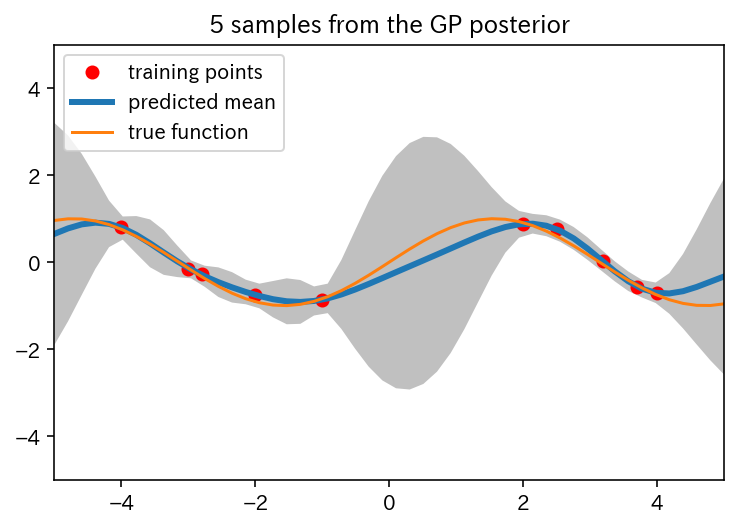

In [4]:
X_test = np.reshape(X_test, [-1])
trp = plt.plot(X_train ,y_train, 'ro', label="training points")
plt.axis([-5, 5, -5, 5])
pred = plt.plot(X_test, mean, lw=3, label="predicted mean")
fun = plt.plot(X_test, np.sin(X_test), label="true function")
plt.fill_between(X_test, mean-2*stdv, mean+2*stdv, facecolor="silver")
plt.legend(loc="upper left")
plt.title(str(n_samples)+' samples from the GP posterior')
plt.show()